<a href="https://colab.research.google.com/github/DCI-alxogm/ml2023-Isaias-Hernandez/blob/main/Sep29-30/MCMC_Metropoli_30_08_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo Markov Chain Metropolis algorithm

Por Isaias Hernández Lares

Draw random samples of the free parameters and accept then or reject them according to the posterior until you reach a maximum of the posterior.

1. Define an initial value of the free parameters.
2. Draw a new random sample of the free parameters from a gaussian distribution centered at the initial values, and with a predefined dispersion.
3. Evaluate the (logarithm) posterior of the initial parameters and that of the proposed parameters and compare them.
  - if the posterior of the porposal is higher than the (logarithm) posterior of the initial parameters accept the proposal and save it.
  - if the (logarithm) posterior of the proposal is lower than the (logarithm) posterior of the initial parameters then generate a random numbr between cero and one, if the radio of the (logarithm) posterior of the proposal and the initial parameter is larger than such number then you accepted the proposal and save it, if not you discard the proposal and keep the initial value.
4. If the porposal was accepted, replace the initial value by such proposal, if not keep the initial sample and repeat step 3.

After many steps, look at the resultant distribution (the chains) of parameters, i.e., the likelihood/posterior

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pdb
from matplotlib.gridspec import GridSpec

In [152]:
#Cargar datos
datos = np.loadtxt("/content/drive/MyDrive/ML2023/olympic100m_men.txt", delimiter=",")
datos_x = datos[:, 0]
datos_y = datos[:, 1]
#Normalizacion
datos_x_norm = (datos_x - np.mean(datos_x))/(np.std(datos_x))

-----------------------------------
Definiendo las funciones de likelihood, prior, posterior en su forma logaritmica

Posterior:
$$lnP \propto ln L + lnPr$$

Likelihood:
$$ ln L \propto -Σ_{i}\left(y_{i} - Model(x_{i},\vec{w})\right)^2-2 σ{i}^{2}$$

$$
y = w_0 + w_1 x
$$

In [12]:
#Modelo
def Modelo(x, theta):
  y = theta[0] + theta[1]*x
  return y

#Para evaluar el likelihood
def Log_Likelihood(x, y, theta, modelo):
  likelihood = -0.5 * np.sum((y - modelo(x, theta))**2)
  return likelihood

#Para evaluar el prior
def Log_Prior(theta, theta_min, theta_max):
  prueba = 1
  for i in range(len(theta)):
    if theta[i] < theta_min[i] or theta[i] > theta_max[i]:
      prueba *= 0
  if prueba == 1:
    prior = 0
  else:
    prior = -np.inf
  return prior

#Para evaluar el posterior
def Log_Posterior(x, y, theta, modelo, theta_min, theta_max):
  likelihood = Log_Likelihood(x, y, theta, modelo)
  prior = Log_Prior(theta, theta_min, theta_max)
  posterior = likelihood + prior
  return posterior

-5739.643721890537

----------------------
Definiendo la función del método MCM Metropoli

In [13]:
def Metropoli(x, y, iteraciones, modelo, theta_i, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior):
  theta_inicial = theta_i
  np.random.normal(theta_inicial[0], sigma_ordenada)
  registro_aceptadas = []
  registro_rechazadas = []
  registro_rechazadas_inf = []
  registro_1 = 0
  registro_2 = 0

  for i in range(iteraciones):
    theta_propuesta = [np.random.normal(theta_inicial[0], sigma_ordenada), np.random.normal(theta_inicial[1], sigma_pendiente)]

    posterior_inicial = Log_Posterior(x, y, theta_inicial, modelo, theta_min, theta_max)
    posterior_propuesta = Log_Posterior(x, y, theta_propuesta, modelo, theta_min, theta_max)

    if posterior_propuesta == -np.inf:
      registro_rechazadas_inf.append(theta_propuesta)
      continue

    if posterior_propuesta > posterior_inicial:
      theta_inicial = theta_propuesta
      registro_aceptadas.append(theta_propuesta)
      registro_1 += 1

    else:
      r = np.log(np.random.uniform())
      if (posterior_propuesta-posterior_inicial) > r:
        theta_inicial = theta_propuesta
        registro_aceptadas.append(theta_propuesta)
        registro_2 += 1

      else:
        registro_rechazadas.append(theta_propuesta)

  cociente_rechazados = np.shape(registro_rechazadas)[0]/iteraciones
  cociente_rechazados_inf = np.shape(registro_rechazadas_inf)[0]/iteraciones
  cociente_aceptacion = np.shape(registro_aceptadas)[0]/iteraciones
  cocientes = [cociente_aceptacion, cociente_rechazados, cociente_rechazados_inf]

  return np.array(registro_aceptadas)

------------------
Obteniendo los resultados, graficando y obteniendo la predicción

In [224]:
#Definiendo variables

theta_min = [0, -1]
theta_max = [15, 0]
iteraciones = 20000
sigma_ordenada = 0.1
sigma_pendiente = 0.02

theta_inicial = [14, -0.001]
resultados = Metropoli(datos_x_norm, datos_y, iteraciones, Modelo, theta_inicial, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior)
theta_inicial = [0.2, -0.8]
resultados2 = Metropoli(datos_x_norm, datos_y, iteraciones, Modelo, theta_inicial, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior)
theta_inicial = [8, -0.36]

resultados3 = Metropoli(datos_x_norm, datos_y, iteraciones, Modelo, theta_inicial, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior)


In [225]:
#Falta el burning (eliminar los datos que no están en la distribución que se ocupa)
n=-int(iteraciones*0.5)
resultados = resultados[n:]
resultados2 = resultados2[n:]
resultados3 = resultados3[n:]

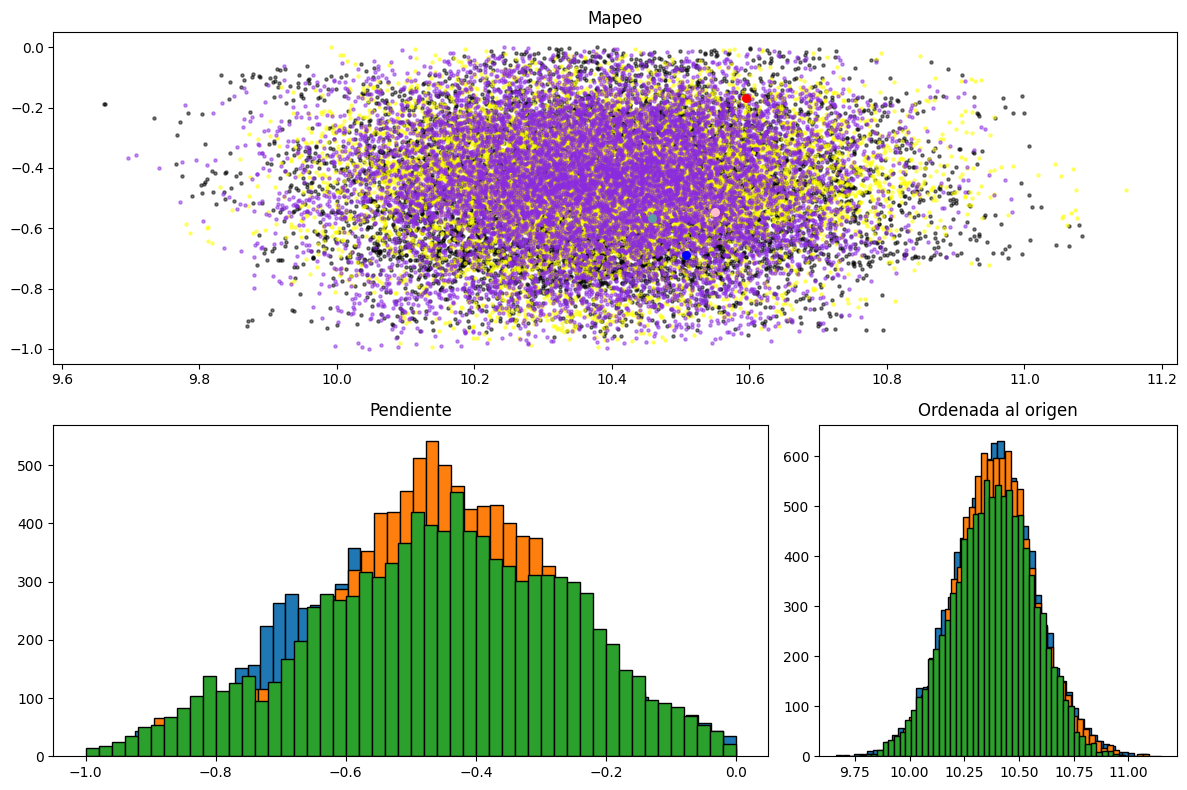

In [226]:
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

# Subplot superior
ax1 = plt.subplot(gs[0, :])
ax1.set_title('Mapeo')

ax1.scatter(resultados[:, 0], resultados[:,1], 5, alpha=0.5, color="black")

ax1.scatter(resultados[:, 0][0], resultados[:, 1][0], 30, "g")

ax1.scatter(resultados2[:, 0], resultados2[:,1], 5, alpha=0.5, color="yellow")

ax1.scatter(resultados2[:, 0][0], resultados2[:, 1][0], 30, "brown")

ax1.scatter(resultados3[:, 0], resultados3[:,1], 5, alpha=0.5, color="#8A2BE2")

ax1.scatter(resultados3[:, 0][0], resultados3[:, 1][0], 30, "#5F9EA0")

# Subplots inferiores
ax2 = plt.subplot(gs[1, 0])
ax2.set_title('Pendiente')
ax2.hist(resultados[:,1], bins=50, edgecolor='black')
ax2.hist(resultados2[:,1], bins=50, edgecolor='black')
ax2.hist(resultados3[:,1], bins=50, edgecolor='black')

ax3 = plt.subplot(gs[1, 1])
ax3.set_title('Ordenada al origen')
ax3.hist(resultados[:,0], bins=50, edgecolor='black')
ax3.hist(resultados2[:,0], bins=50, edgecolor='black')
ax3.hist(resultados3[:,0], bins=50, edgecolor='black')

#ax1.scatter(10., -0.46, 30, color="orange")
ax1.scatter(resultados[:, 0][-1], resultados[:, 1][-1], 30, "r")
ax1.scatter(resultados3[:, 0][-1], resultados3[:, 1][-1], 30, "#0000FF")
ax1.scatter(resultados2[:, 0][-1], resultados2[:, 1][-1], 30, "pink")
plt.tight_layout()
plt.show()

In [251]:
prediccion = []

counts, bins = np.histogram(resultados3[:, 0], bins=20)
mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
prediccion.append(mean_value)

counts, bins = np.histogram(resultados3[:, 1], bins=20)
mean_value = np.sum(bins[:-1] * counts) / np.sum(counts)
prediccion.append(mean_value)

print("Predicción:", prediccion)

Predicción: [10.34761373673272, -0.4815863110484641]


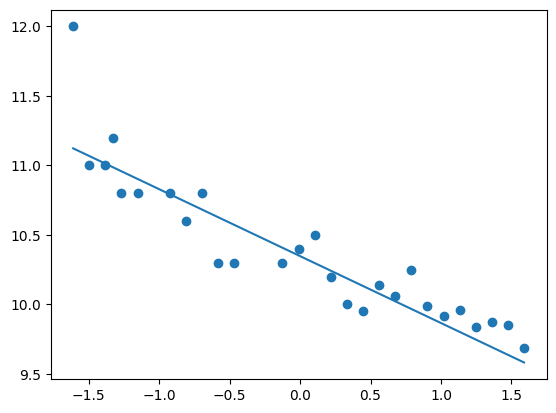

In [252]:
plt.scatter(datos_x_norm, datos_y)
y = Modelo(datos_x_norm, prediccion)
plt.plot(datos_x_norm, y)

La predicción hecha por el método Monte Carlo para el modelo lineal es: 10.379 ordenada al origen y -0.4620. Método aplicado a valores normalizados. Predicción esperada de valores cercanos a: 10 de ordenada y -0.46 de pendiente.


----------------
#Criterios de convergencia

* Check for low/high acceptamce rates
* Run long chains
* Look at the sequence of chains
* Run several chains, initialized in different points of the parameter space
* Different segments of the chain give the same result


$$
s_{i}^{2} = \frac{1}{n-1}∑_{t=1}^{n}(X_{it}-\bar{X}_{i})^2
$$

$$
s^{2} = \frac{1}{m}∑_{i=1}^{m} s_{i}^{2}
$$

Donde:

* $\bar{X}$ Mean from chain i (for a given parameter)
* $s_{i}$ Variance for chain i
* n samples in a chain
* m chains
* $\hat{μ}$ Overall mean for a given parameter

Compute
$$
\frac{B}{n} = \frac{1}{m-1}∑_{i=1}^{m}(\bar{X}_{i} - \hat{μ})^{2}
$$
$$
\hat{σ}^{2} = \frac{n-1}{n}s^{2}+\frac{B}{n}
$$
$s^{2}$ and $\hat{σ}^{2}$ are both stimates of $\hat{σ}^{2}$
$$
\hat{R} = \sqrt{\frac{\hat{σ}^{2}}{s^{2}}}
$$

when $\hat{R} \leq δ$ for some $δ > 1$ the chain might have converged

In [253]:
m = 5
n = 2000
np.random.uniform(theta_min[0], theta_max[0])
cadenas = []
for i in range(m):
  b = np.random.uniform(theta_min[0], theta_max[0])
  w = np.random.uniform(theta_min[1], theta_max[1])
  theta = [b, w]
  cad = Metropoli(datos_x_norm, datos_y, iteraciones, Modelo, theta, theta_min, theta_max, sigma_pendiente, sigma_ordenada, Log_Likelihood, Log_Prior, Log_Posterior)
  cad = cad[-n:]
  cadenas.append(cad)
cadenas = np.array(cadenas)

In [254]:
Xi = np.zeros((m, cadenas.shape[-1]))
for i in range(m):
  for j in range(cadenas.shape[-1]):
    promedios = 1/n * np.sum(cadenas[i, :, j])
    Xi[i, j] = promedios
Xi

array([[10.39058087, -0.50346808],
       [10.38086319, -0.47210045],
       [10.34793386, -0.39060524],
       [10.40060612, -0.33582898],
       [10.39611204, -0.38550305]])

In [255]:
si = np.zeros((m, cadenas.shape[-1]))
for i in range(m):
  for j in range(cadenas.shape[-1]):
    varianza = 1/(n-1) * np.sum((cadenas[i, :, j] - Xi[i, j])**2)
    si[i, j] = varianza
np.sqrt(si)


array([[0.18151181, 0.18385953],
       [0.20102869, 0.15248102],
       [0.1840365 , 0.13545884],
       [0.18635372, 0.14863013],
       [0.19191237, 0.12689397]])

In [256]:
W = np.zeros((cadenas.shape[-1]))
for i in range(cadenas.shape[-1]):
  mean = 1/m * np.sum(si[:,i])
  W[i] = mean
W

array([0.03575731, 0.02271938])

In [257]:
mu = np.zeros((cadenas.shape[-1]))
for i in range(cadenas.shape[-1]):
  mean = 1/m * np.sum(Xi[:,i])
  mu[i] = mean
mu

array([10.38321921, -0.41750116])

In [258]:
Bn = np.zeros(2)
for i in range(2):
  bn = 1/(m-1) * np.sum((Xi[:,i]-mu[i])**2)
  Bn[i] = bn
Bn

array([0.00044333, 0.00469725])

In [259]:
sigma = np.zeros(2)
sigma = (n-1)/n * W + Bn
sigma

array([0.03618277, 0.02740527])

In [260]:
R = np.sqrt(sigma/W)
R

array([1.0059316 , 1.09829456])

Como el valor de R para ambos parametros es aproximado a 1, aseguramos que converge.

---------
Graficando la distribución de los parametros ordenada y pendiente con sus percentiles (a 1 desviación estandar, es decir, 67% de los datos)

Text(0.5, 1.0, 'Ordenada')

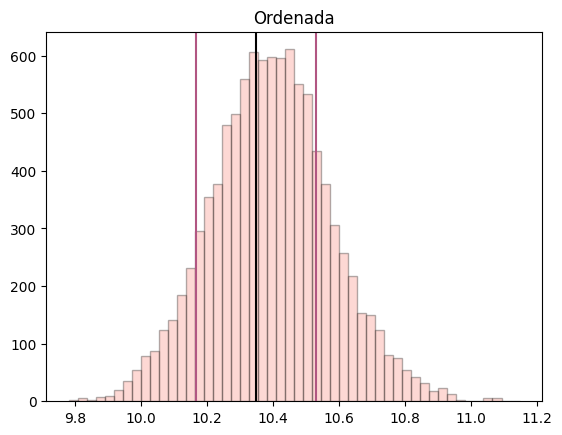

In [278]:
#Calcular percentiles (la grafica con la desviacion estandar)

plt.hist(resultados2[:,0], bins=50, edgecolor="black", alpha=.3, color="#FA8072")
#plt.hist(cadenas[0, :, 0], color="green",edgecolor="black", alpha=.3, bins=100)
plt.axvline(prediccion[0], color="black")
plt.axvline(prediccion[0]+np.sqrt(si[0,0]), color="#B15682")
plt.axvline(prediccion[0]-np.sqrt(si[0,0]), color="#B15682")
plt.title("Ordenada")

Text(0.5, 1.0, 'Pendiente')

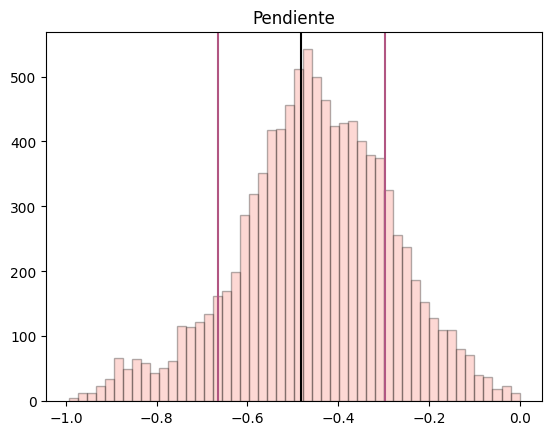

In [277]:
plt.hist(resultados2[:,1], bins=50, edgecolor="black", alpha=.3, color="#FA8072")
#plt.hist(cadenas[0, :, 1], edgecolor="black", alpha=.3, bins=20)
plt.axvline(prediccion[1], color="black")
plt.axvline(prediccion[1]+np.sqrt(si[0,1]), color="#B15682")
plt.axvline(prediccion[1]-np.sqrt(si[0,1]), color="#B15682")
plt.title("Pendiente")

-------------------------